In [1]:
"""
Leo Fleury
Codename: Project Cygnus 

Gyurkovics analyzes Visual & Audio Oddball tasks to demonstrate that "stimulus-
induced changes in 1/f activity, detectable at lower frequencies, are
independent of event-related potentials." This is achieved by separating pre-
and post-event windows to let the stimulus onset affect the 1/f, then
subtracting ERP frequencies from this post-event data. Project Cygnus is a 
re-analysis of this paper, aiming to verify whether stimulus-induced 1/f 
changes are separable from event-related potentials across different
ERPs—starting with P3 (a similar ERP) and extending to the N400, a more 
cognitively demanding task. Gyurkovics suggests that the slope change increases
with cognitive task difficulty, though the tasks in their study were not
highly demanding.
"""

'\nLeo Fleury\nCodename: Project Cygnus \n\nGyurkovics analyzes Visual & Audio Oddball tasks to demonstrate that "stimulus-\ninduced changes in 1/f activity, detectable at lower frequencies, are\nindependent of event-related potentials." This is achieved by separating pre-\nand post-event windows to let the stimulus onset affect the 1/f, then\nsubtracting ERP frequencies from this post-event data. Project Cygnus is a \nre-analysis of this paper, aiming to verify whether stimulus-induced 1/f \nchanges are separable from event-related potentials across different\nERPs—starting with P3 (a similar ERP) and extending to the N400, a more \ncognitively demanding task. Gyurkovics suggests that the slope change increases\nwith cognitive task difficulty, though the tasks in their study were not\nhighly demanding.\n'

In [2]:
import mne
import matplotlib.pyplot as plt
import numpy as np 
from scipy.fft import fft, fftfreq

In [4]:
# Read the file using MNE
file_path = "C:/Users/leofl/OneDrive/Desktop/ERP Data/Project Cygnus/p3_1.set"
p3 = mne.io.read_raw_eeglab(file_path, preload=True)

Reading C:\Users\leofl\OneDrive\Desktop\ERP Data\Project Cygnus\p3_1.fdt


C:\Users\leofl\AppData\Local\Temp\ipykernel_7184\2471413281.py:3: RuntimeWarning: Data file name in EEG.data (1_P3_shifted_ds_reref_ucbip_hpfilt_ica_weighted.fdt) is incorrect, the file name must have changed on disk, using the correct file name (p3_1.fdt).
  p3 = mne.io.read_raw_eeglab(file_path, preload=True)


Reading 0 ... 119551  =      0.000 ...   466.996 secs...


In [5]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
p3.rename_channels({"FP1":'Fp1','FP2':'Fp2'})
p3.set_channel_types({'HEOG_left':'eog', 'HEOG_right':'eog', \
                       'VEOG_lower':'eog', '(uncorr) HEOG' : 'eog',\
                       '(uncorr) VEOG' : 'eog'})
p3.set_montage(ten_twenty_montage)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,31 points
Good channels,"28 EEG, 5 EOG"
Bad channels,None
EOG channels,"HEOG_left, HEOG_right, VEOG_lower, (uncorr) HEOG, (uncorr) VEOG"
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


In [6]:
p3.info['ch_names']

['Fp1',
 'F3',
 'F7',
 'FC3',
 'C3',
 'C5',
 'P3',
 'P7',
 'PO7',
 'PO3',
 'O1',
 'Oz',
 'Pz',
 'CPz',
 'Fp2',
 'Fz',
 'F4',
 'F8',
 'FC4',
 'FCz',
 'Cz',
 'C4',
 'C6',
 'P4',
 'P8',
 'PO8',
 'PO4',
 'O2',
 'HEOG_left',
 'HEOG_right',
 'VEOG_lower',
 '(uncorr) HEOG',
 '(uncorr) VEOG']

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8449 samples (33.004 s)

Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished


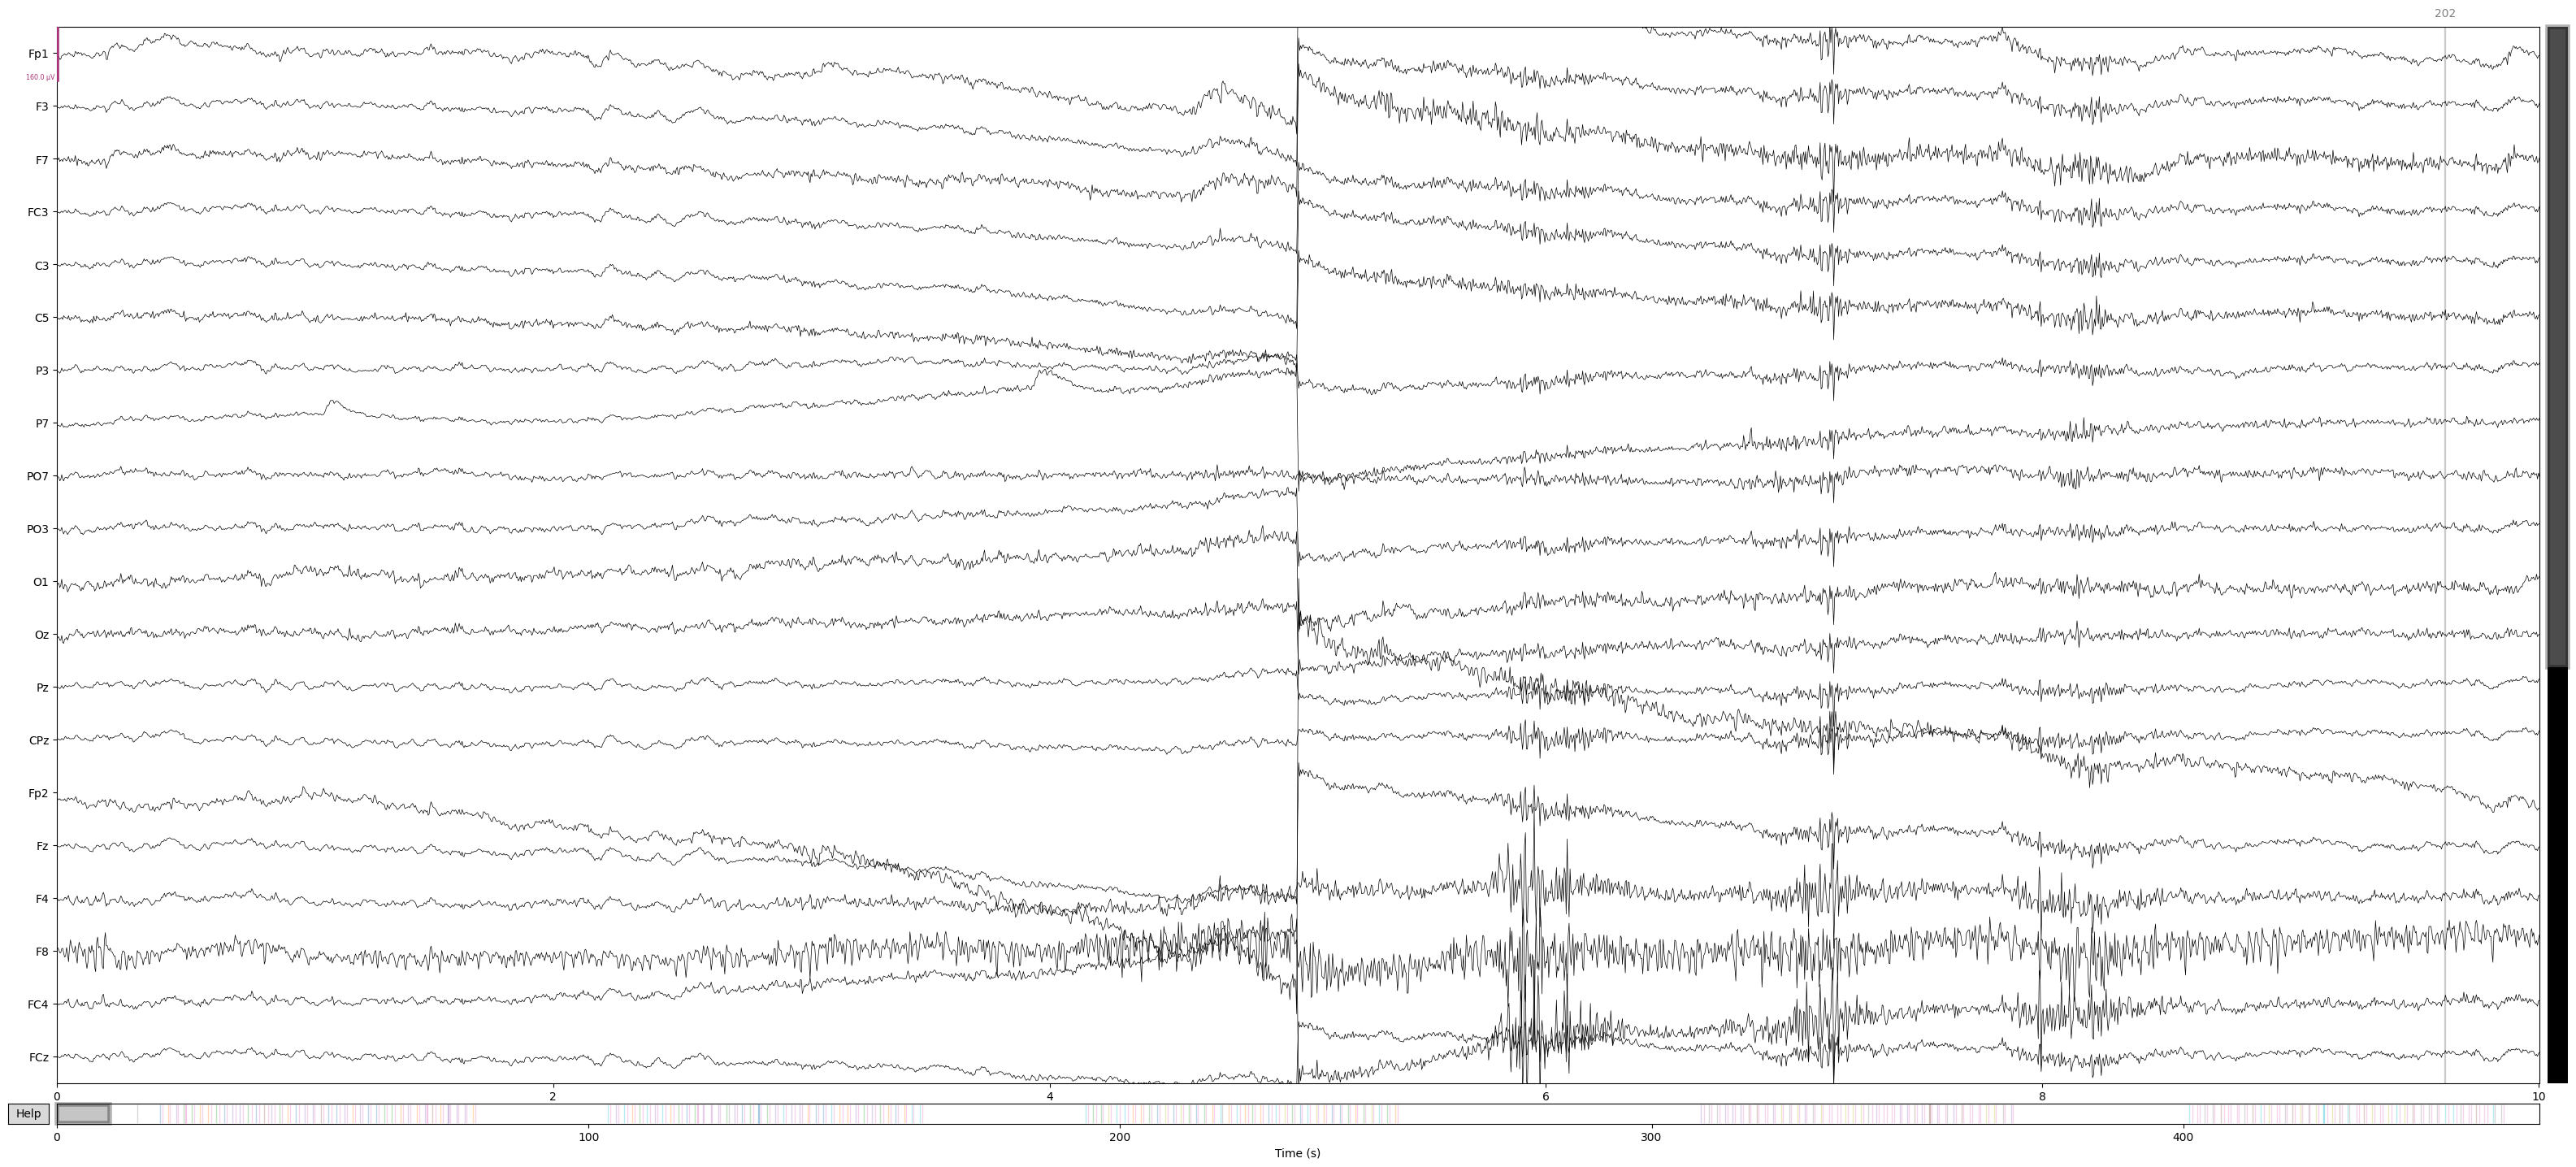

In [7]:
#filtering and scaling bc other formats will make the data look unreasonable
p3.copy().filter(0.1, 100).plot(scalings=0.00008, clipping=None)
plt.show() 

In [8]:
# event_p3 is 2d array with inside lists having 3 spots
# column 0 is the sample indices (time point) where the event occurs
# column 2 is the event IDs
event_p3, event_id_p3 = mne.events_from_annotations(p3)
# event_id_p3 is a dictionary mapping the ecent descriptions to the ID so can know what is what

#removing wrong or right markers in event p3 (in this case 6 or 7)  -- not nescessary for analysis
event_p3_minus67 = [array for array in event_p3 if array[2] \
                    != 6 and array[2] != 7]

Used Annotations descriptions: ['11', '12', '13', '14', '15', '201', '202', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45', '51', '52', '53', '54', '55']


In [9]:
# actual event code scheme showing target and nontarget trials
event_id_p3_epoch = {
    "target": [1, 9, 15, 21, 27],  # got the #s fom the event_id array (11,22 etc. were the oddball events/ triggers)
    "nontarget": [2, 3, 4, 5, 8, 10, 11, 12, 13,
                  14, 16, 17, 18, 19,
                  20, 22, 23, 24, 25, 
                  26]
}

In [10]:
# this for loop reformats the codes in the event scheme to give info about
# frequent_rare, rare_frequent, and frequent_frequent
# it doesnt create a new event_code scheme bcs. need to refer to prev indices
# to create future ones
for array in range(len(event_p3_minus67)):
    if event_p3_minus67[array][2] in event_id_p3_epoch['target']:
        event_p3_minus67[array][2] = 100
    elif array > 0 and event_p3_minus67[array][2] in event_id_p3_epoch['nontarget'] and event_p3_minus67[array - 1][2] == 100:
        event_p3_minus67[array][2] = 200
    elif array > 0 and event_p3_minus67[array][2] in event_id_p3_epoch['nontarget'] and event_p3_minus67[array - 1][2] == 200 or event_p3_minus67[array - 1][2] == 300:
        event_p3_minus67[array][2] = 300

event_p3_minus67

[array([4976,    0,  100]),
 array([5347,    0,  200]),
 array([5735,    0,  300]),
 array([6102,    0,  300]),
 array([6507,    0,  300]),
 array([6900,    0,  300]),
 array([7296,    0,  300]),
 array([7676,    0,  300]),
 array([8043,    0,  100]),
 array([8444,    0,  200]),
 array([8806,    0,  300]),
 array([9203,    0,  300]),
 array([9587,    0,  100]),
 array([9962,    0,  200]),
 array([10346,     0,   300]),
 array([10725,     0,   300]),
 array([11127,     0,   300]),
 array([11523,     0,   100]),
 array([11920,     0,   200]),
 array([12321,     0,   300]),
 array([12717,     0,   300]),
 array([13088,     0,   100]),
 array([13455,     0,   100]),
 array([13835,     0,   200]),
 array([14232,     0,   300]),
 array([14603,     0,   300]),
 array([14978,     0,   100]),
 array([15362,     0,   100]),
 array([15758,     0,   200]),
 array([16129,     0,   300]),
 array([16535,     0,   300]),
 array([16919,     0,   300]),
 array([17328,     0,   300]),
 array([17729,     

In [11]:
new_event_id_p3_epoch = {
      "frequent_rare": 100, 
      "rare_frequent": 200, 
      "frequent_frequent": 300
}

In [12]:
# here is the final application to create the epochs
#p3 is a mne.io.raw object (n_channels, n_times)
# here we determine the time window for the epochs which we set to -.6 to .6 
# preload = true speeds up data processing but more memory intensive
epochs = mne.Epochs(p3, events = event_p3_minus67, 
                    event_id = new_event_id_p3_epoch,
                    tmin  = -.6, tmax = .6,
                    picks = ['Pz'],
                    baseline = None,
                    preload=True) 
epochs

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 309 original time points ...
0 bad epochs dropped


Number of events,200
Events,frequent_frequent: 127frequent_rare: 40rare_frequent: 33
Time range,-0.602 – 0.602 s
Baseline,off


In [13]:
# here we have to seperate both parts of each epoch
# we are setting are window to -.6 to .6 bcs that is the largest window size
# we can create with the p3 data set
epochs_pre_stimulus_window = epochs.copy().crop(tmin=-.6, tmax=0)
epochs_post_stimulus_window = epochs.copy().crop(tmin=0, tmax= .6)

Need more than one channel to make topography for eeg. Disabling interactivity.


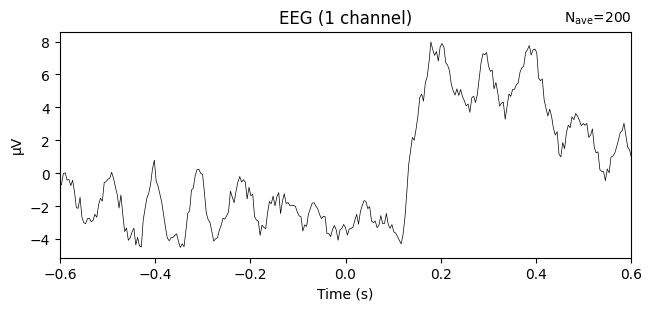

In [14]:
# computing ERP 
erp = epochs.average() 
erp.plot()
plt.show()

C:\Users\leofl\AppData\Local\Temp\ipykernel_7184\2000337208.py:14: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  post_data = epochs_post_stimulus_window.get_data()


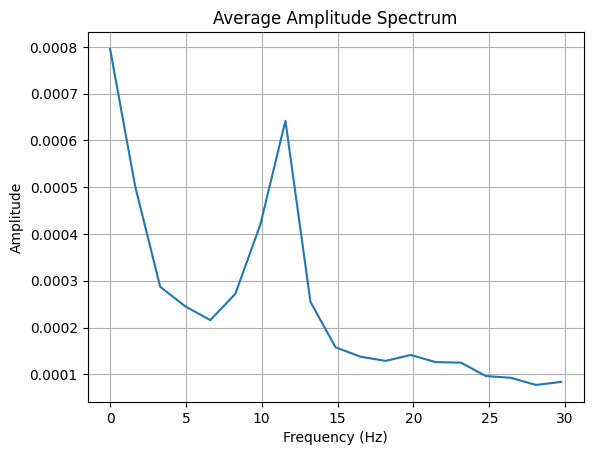

In [ ]:
n_epochs = 0
n_channels = 1
n_times = 2

# the sample rate is how many samples are recorded per second (256hz for us)
sample_rate = epochs_post_stimulus_window.info['sfreq']

# len(epochs.times) gives you number_of_samples
# duration = number_of_samples / sample_rate (duration for one epoch )
duration = len(epochs_post_stimulus_window.times) / sample_rate
# duration as expected is 1.2 since our window is -0.6 to .6 

# post_data gives you the raw epoch data as a nested dictionary 
post_data = epochs_post_stimulus_window.get_data()
# --> n_epochs, n_channels, n_times (time points in each epoch)
# so N is the number of time poitns in each epoch 
N = post_data.shape[n_times]

# yf applies fft and give it the raw post_data and applies it along the time [2]
yf = fft(post_data, axis=n_times)
# Resulting Data (yf): The resulting yf array has the same shape as post_data: (n_epochs, n_channels, n_times).
# data along the n_times dimension now represents frequency components instead of time points.

yf_avg = np.mean(np.abs(yf), axis=(n_epochs, n_channels))

# xf to get the freq bins & need the inverse sample rate & num time points
# 1/ sample_rate is the sample spacing (time interval between samples)
xf = fftfreq(N, 1 / sample_rate)
mask = xf[:N // 2] <= 30

plt.plot(xf[:N // 2][mask], yf_avg[:N // 2][mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Average Amplitude Spectrum')
plt.grid(True)
plt.show()


In [16]:
print(yf.shape)
print(xf.shape)
print(yf_avg.shape)


(200, 1, 155)
(155,)
(155,)


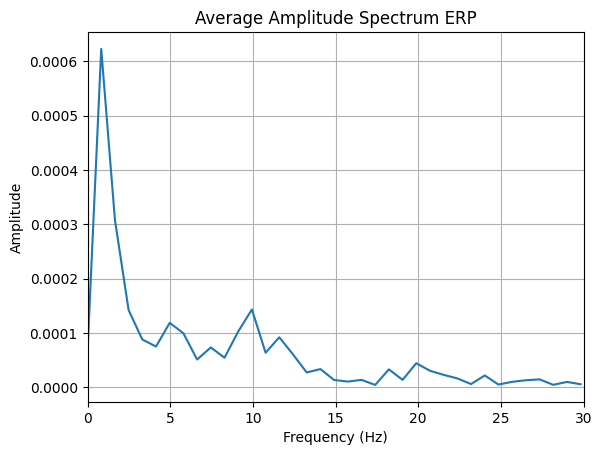

In [17]:
n_channels2 = 0 
n_times2 = 1

#Graphing the ERP
#sample rate is also 256
sample_rate2 = erp.info['sfreq']

# len(erp.times) which is num of samples is 309 
duration2 = len(erp.times) / sample_rate2

# here the diff between erp.data and epoch data is that erp is 2d vs 3d
data2 = erp.data

# here since erp.data is a 2d array to acess the times we acess the 1st index
N2 = data2.shape[n_times2]

# yf2 is a var where fft was applied to each time point individually -- no 
#need for a for loop since already applied individually (output is a array)
# of same dimensions and length as erp.data
yf2 = fft(data2, axis=1)

#however to be able to compute the graph average we use np.mean across the epoch axis
yf_avg2 = np.mean(np.abs(yf2), axis= n_channels2)

#lastly we compute the freq bins using the inverse of the sample rate
# remember that sampel rate is how many samples are recorded per second
xf2 = fftfreq(N2, 1 / sample_rate2)

# apply a mask becayse we dont care about frequencies above 30 
mask2 = xf2[:N2//2] <= 30

plt.plot(xf2[:N2//2][mask2], yf_avg2[:N2//2][mask2]) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Average Amplitude Spectrum ERP')
plt.xlim(0, 30)
plt.grid(True)
plt.show()


In [18]:
post_minus_erp_yf = yf_avg - yf_avg2

plt.plot(xf2[:N2//2][mask2], post_minus_erp_yf[:N2//2][mask2]) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Average Amplitude Spectrum ERP')
plt.xlim(0, 30)
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (155,) (309,) 

In [21]:
yf_avg.shape

(155,)